# Financial Market Analysis using Recurrent Neural Network

* Ref: Fabrice Daniel, Financial Time Series Data Processing for Machine Learning, arXiv:1907.03010
* Financial data clearly has trends, meaning that it is not a stationary time series. To test for stationarity two criterions are Augmented Dickey-Fuller test (ADF) and pvalue. 
* Some methods to make it staionary is differencing using df['Open'].diff().fillna(0.0), or to compute the daily return which is df['DailyReturn'] = df['Close'] - df['Open']. 
* Note that differencing is identical to return if nobody trades after market. 
* To train a time series data, typically one creates time windows as inputs, for instance a time window of 20 consecutive days. (This is the "look back period" for forecasting)
* Specially, build a training set S consisting of series $\hat{X}=\{X_0,X_1,\dots,X_{K-1}\}$, where $X_t=\{x_{t-n},\dots,x_{t-1}\}$, and prediction as $\hat{Y}=\{y_0,y_1,\dots,y_{K-1}\}$ where $y_t=\{x_{t}\}$.
* Note that this is a overlapping window of time series. As a result, the train/validation/test set split must also be chronological.
* Identify training objectives. This could be many. The simplest is the mean square error metric, which measures how close is the predicted price to the actual price. 
* Next we can look at various classifiers, such as the closing price at t is greater than the closing price at t-5 (i.e., predict a five day trend.). This converts the regression model to a classification problem. 
* Next we look at multi-day forecasting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline

                               Open      High       Low     Close      Volume  \
Date                                                                            
1986-03-13 00:00:00-05:00  0.054693  0.062736  0.054693  0.060055  1031788800   
1986-03-14 00:00:00-05:00  0.060055  0.063272  0.060055  0.062199   308160000   
1986-03-17 00:00:00-05:00  0.062199  0.063808  0.062199  0.063272   133171200   
1986-03-18 00:00:00-05:00  0.063272  0.063808  0.061127  0.061663    67766400   

                           Dividends  Stock Splits  
Date                                                
1986-03-13 00:00:00-05:00        0.0           0.0  
1986-03-14 00:00:00-05:00        0.0           0.0  
1986-03-17 00:00:00-05:00        0.0           0.0  
1986-03-18 00:00:00-05:00        0.0           0.0  


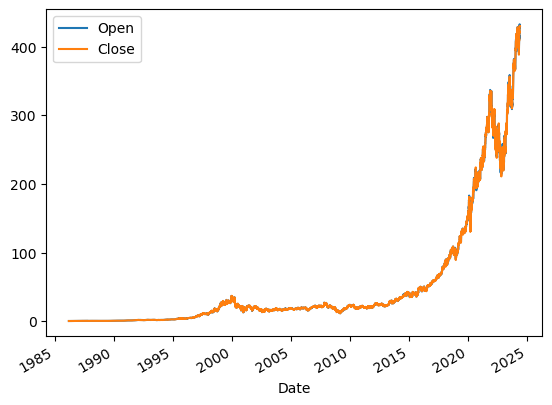

In [2]:
# Yahoo Finance has a nice API
import yfinance as yahooFinance
# GetInformation = yahooFinance.Ticker("^IXIC")
GetInformation = yahooFinance.Ticker("MSFT")
df = GetInformation.history(period="max")
print(df.head(4))
df.plot(y=['Open','Close'])
plt.show()

# Create time windows of size n_window, and multiday forecasting n_forecast 

In [57]:
def create_time_windows(df, n_window ,n_forecast ): 
    '''
        This creates a rolling time window (X,y) from the Pandas DataFrame df, and store it in a numpy array of size (nsamples, n_window/n_forecast, nfeatures)
        n_features referr to open/close/volume etc, while also going through a min-max scaler from -1 to 1 for all time windows
    '''
    N, N_features = len(df), len(list(df))
    X, y = [], []
    sc = MinMaxScaler(feature_range=(0,1))
    for i in range(n_window,N-n_forecast):
        # X.append(df.iloc[(i-n_window):i].to_numpy())
        # y.append(df.iloc[i:(i+n_forecast)].to_numpy())
        tmp = df.iloc[(i-n_window):(i+n_forecast)].to_numpy()
        tmp = sc.fit_transform(tmp)
        X.append(tmp[:n_window,...])
        y.append(tmp[n_window:,...])

    # for i in range(N):
    #     if (i+1) * (n_window+n_forecast) <= N:
    #         tmp = df.iloc[(i * (n_window+n_forecast)):((i+1)*(n_window+n_forecast))].to_numpy()
    #         tmp = sc.fit_transform(tmp)
    #         X.append(tmp[:n_window,...])
    #         y.append(tmp[n_window:,...])
        
    return np.array(X), np.array(y)

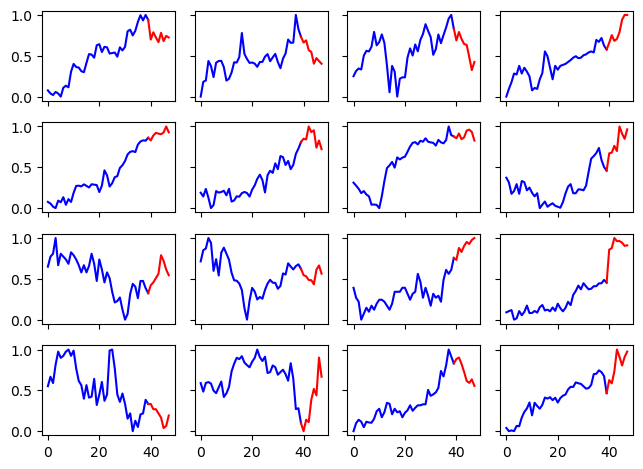

In [58]:
n_window, n_forecast = 8*5, 8*1
X, y = create_time_windows(df, n_window = n_window, n_forecast = n_forecast)

fig, ax = plt.subplots(4,4,sharex=True,sharey=True)
samples = [[np.random.randint(0,X.shape[0]) for _ in range(4)] for _ in range(4)]
for r in range(4):
    for c in range(4):
        idx= samples[r][c]
        ax[r,c].plot(range(n_window),X[idx,:,0],"b-")
        ax[r,c].plot(range(n_window-1,n_window+n_forecast),np.concatenate([X[idx,-1:,0],y[idx,:,0]]),"r-")
plt.tight_layout()
plt.show()
plt.close()

# Perform time series splitting into train and test data, use 0.8 0.2

In [5]:
Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]
print(ytrain.shape)

(7664, 8, 7)


In [51]:
def plot_regression_results(X,y,model=0,mode='test'):
  fig, ax = plt.subplots(4,4,figsize=(8,6),sharex=True,sharey=True)
  for r in range(4):
    for c in range(4):
        idx = np.random.randint(X.shape[0])
        ax[r,c].plot(range(X.shape[1]),X[idx,:,0],"b-",label='train')
        ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),y[idx,:,0],"r-",label='actual')
        if model != 0:
            val = model(X[idx:(idx+1),:,:1])
            ax[r,c].plot(range(X.shape[1],X.shape[1]+y.shape[1]),val[0],"g-",label='pred.')
        if r ==0 and c ==0:
          ax[r,c].legend(fontsize=9)
  fig.suptitle(mode)
  plt.tight_layout()
  plt.show()
  plt.close()

# LSTM modeling 40 days forecast 8 days 
- 2 LSTM layers (32 neurons each) with layer dropout during traiing 

In [7]:
nfeatures = 1 # only use first nfeature columns for training and prediction
model1= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(n_forecast)])
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='MSE')
ntrain = int(Xtrain.shape[0]*0.8)
history = model1.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))
model1.save('models/Regression_LSTM_Predict_8Days_May28_648PM.keras')

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1464 - val_loss: 0.0586
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0569 - val_loss: 0.0485
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0528 - val_loss: 0.0489
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0480 - val_loss: 0.0453
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0470 - val_loss: 0.0451
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0450 - val_loss: 0.0470
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0445 - val_loss: 0.0439
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0431 - val_loss: 0.0436
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0424 - val_loss: 0.0441
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0420 - val_loss: 0.0422
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0402 - val_loss: 0.0416
Epoch 12/100
192/192 ━━━━━━━━━

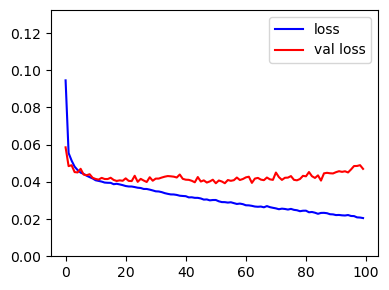

In [14]:
fig = plt.figure(figsize=(4,3))
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val loss')
plt.ylim([0,1.4*max(history.history['loss'])])
# plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

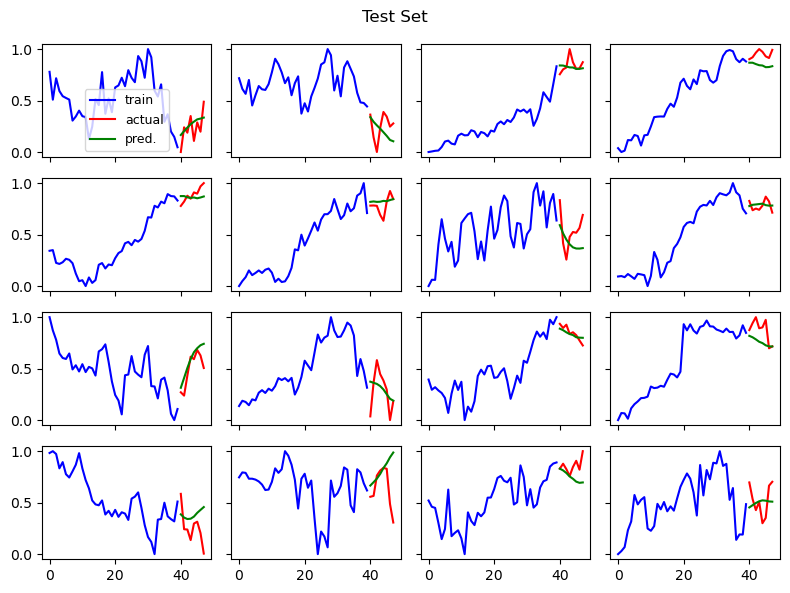

In [16]:
plot_regression_results(Xtest,ytest,model=model1,mode='Test Set')
# plot_regression_results(Xtrain[:ntrain,...],ytrain[:ntrain,...],model=model1,mode='Train Set')

# LSTM model and predict 1 
- use iteratively solve for data points after 1 

In [52]:
n_window, n_forecast = 8*5, 1*1
X, y = create_time_windows(df, n_window = n_window, n_forecast = n_forecast)
Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

nfeatures = 1 # only use first nfeature columns for training and prediction
model2= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.LSTM(32,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(32,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1)])
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss='MSE')
ntrain = int(Xtrain.shape[0]*0.8)
history = model2.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1615 - val_loss: 0.0445
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0455 - val_loss: 0.0337
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0368 - val_loss: 0.0275
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0302 - val_loss: 0.0232
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0261 - val_loss: 0.0212
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0239 - val_loss: 0.0193
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0230 - val_loss: 0.0200
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0224 - val_loss: 0.0180
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0212 - val_loss: 0.0179
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0218 - val_loss: 0.0177
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0211 - val_loss: 0.0176
Epoch 12/100
192/192 ━━━━━━━━━

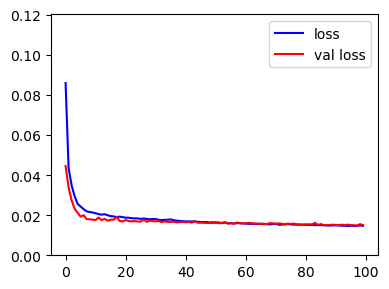

In [53]:
fig = plt.figure(figsize=(4,3))
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val loss')
plt.ylim([0,1.4*max(history.history['loss'])])
# plt.yscale('log')
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

In [54]:
model2.save('models/Regression_LSTM_Predict_1Days_May28_705PM.keras')

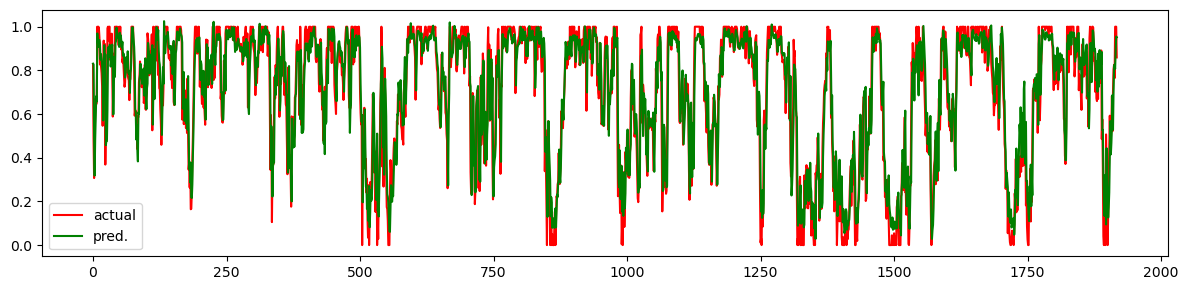

In [56]:
# plot predictions based on model 2
def plot_forecast(X,y,model):
    # only do this for the test data set! 
    ypred = model(X[:,:,:1])
    fig = plt.figure(figsize=(12,3))
    plt.plot(y[:,0,0],"r-",label="actual")
    plt.plot(ypred[:,0],"g-",label="pred.")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecast(Xtest,ytest,model2)

In [21]:
# plot predictions based on model 2, transformer to orginal model

# Train LSTM classifiers 
- train classifier to forecast if price is higher/lower than five days prior
- use sigmoid output 

In [97]:
n_window, n_forecast = 8*5, 1*1
X, y = create_time_windows(df, n_window = n_window, n_forecast = n_forecast)
for i in range(y.shape[0]):
    for j in range(y.shape[2]): # features
        if y[i,0,j] < X[i,-5,j]:
            y[i,0,j] =  0 
        else: 
            y[i,0,j] =  1

Nsamples = X.shape[0]
Ntrain = int(Nsamples * 0.8) 
Xtrain, ytrain = X[:Ntrain,...], y[:Ntrain,...]
Xtest, ytest = X[Ntrain:,...], y[Ntrain:,...]

nfeatures = 1 # only use first nfeature columns for training and prediction
model3= keras.Sequential([keras.Input(shape=(None,nfeatures)),
                          keras.layers.LSTM(20,return_sequences=True),
                          keras.layers.Dropout(0.2),
                          keras.layers.LSTM(20,return_sequences=False),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1,activation='sigmoid')])
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),loss='binary_crossentropy',metrics=['accuracy'])
ntrain = int(Xtrain.shape[0]*0.8)
history = model3.fit(Xtrain[:ntrain,:,:nfeatures],ytrain[:ntrain,:,0], batch_size= 32,
                     epochs = 100,validation_data=(Xtrain[ntrain:,:,:nfeatures],ytrain[ntrain:,:,0]))
model3.save('models/Classification_LSTM_C5_NoDropout_May28_812PM.keras')

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5840 - loss: 0.6661 - val_accuracy: 0.8162 - val_loss: 0.4251
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7842 - loss: 0.4497 - val_accuracy: 0.8110 - val_loss: 0.4164
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8252 - loss: 0.4068 - val_accuracy: 0.8175 - val_loss: 0.4043
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8109 - loss: 0.4204 - val_accuracy: 0.8044 - val_loss: 0.4201
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8258 - loss: 0.3904 - val_accuracy: 0.8377 - val_loss: 0.3617
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8243 - loss: 0.3885 - val_accuracy: 0.8527 - val_loss: 0.3503
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8266 - loss: 0.3721 - val_accuracy: 0.8533 - val_loss: 0.3551
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8379 - loss: 0.3679 - val_acc

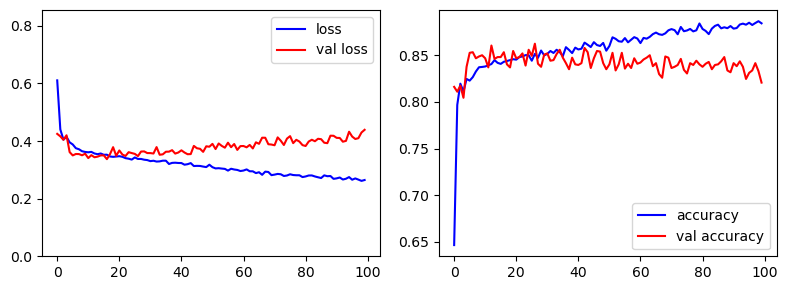

In [98]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(history.history['loss'],'b-',label='loss')
ax[0].plot(history.history['val_loss'],'r-',label='val loss')
ax[0].set_ylim([0,1.4*max(history.history['loss'])])
ax[0].legend()
ax[1].plot(history.history['accuracy'],'b-',label='accuracy')
ax[1].plot(history.history['val_accuracy'],'r-',label='val accuracy')
ax[1].legend()
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

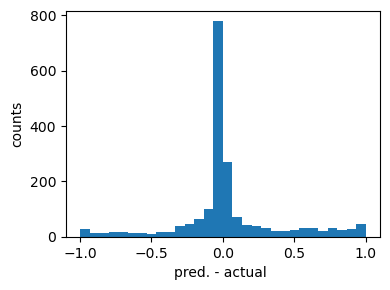

In [99]:
# plot confidence value versus real result
def plot_forecast_classifier(X,y,model):
    # only do this for the test data set! 
    yactual = y[:,0,0]
    ypred = model(X[:,:,:1]).numpy().flatten()
    fig = plt.figure(figsize=(4,3))
    # plt.plot(yactual[idx],"r.",label="actual")
    # plt.plot(ypred[idx],"gx",label="pred.")
    plt.hist(ypred-yactual,bins=30)
    plt.xlabel('pred. - actual ')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.show()
    plt.close(fig)
plot_forecast_classifier(Xtest,ytest,model3)
